## Dimensionality Reduction and Unsupervised Clustering for EELS-SI
Jinseok Ryu (jinseuk56@gmail.com)<br>
Electron Microscopy and Spectroscopy Lab.<br>
Dept. of Materials Science and Engineering, Seoul National University<br>

This notebook demonstrates an example of the research work described in <u><strong>J. Ryu et al. (2021), Ultramicroscopy.</strong></u> (https://doi.org/10.1016/j.ultramic.2021.113314)<br>
To obtain the detailed information, please read the article.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS
import tkinter.filedialog as tkf
import tifffile
import ipywidgets as pyw
import time

In [2]:
# create a customized color group
color_rep = ["black", "red", "green", "blue", "orange", "purple", "yellow", "lime", 
             "cyan", "magenta", "lightgray", "peru", "springgreen", "deepskyblue", 
             "hotpink", "darkgray"]

custom_cmap = mcolors.ListedColormap(color_rep)
bounds = np.arange(-1, len(color_rep))
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(color_rep))
sm = cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])

cm_rep = ["gray", "Reds", "Greens", "Blues", "Oranges", "Purples"]

In [3]:
def zero_one_rescale(spectrum):
    """
    normalize one spectrum from 0.0 to 1.0
    """
    spectrum = spectrum.clip(min=0.0)
    min_val = np.min(spectrum)
    
    rescaled = spectrum - min_val
    
    if np.max(rescaled) != 0:
        rescaled = rescaled / np.max(rescaled)
    
    return rescaled

In [4]:
def reshape_coeff(coeffs, new_shape):
    """
    reshape a coefficient matrix to restore the original scanning shapes
    """
    coeff_reshape = []
    for i in range(len(new_shape)):
        temp = coeffs[:int(new_shape[i, 0]*new_shape[i, 1]), :]
        coeffs = np.delete(coeffs, range(int(new_shape[i, 0]*new_shape[i, 1])), axis=0)
        temp = np.reshape(temp, (new_shape[i, 0], new_shape[i, 1], -1))
        #print(temp.shape)
        coeff_reshape.append(temp)
        
    return coeff_reshape

In [5]:
def label_arrangement(label_arr, new_shape):
    """
    reshape a clustering result to restore the original scanning shapes
    """
    label_sort = np.unique(label_arr)
    #print(label_sort)
    num_label = len(label_sort)
    hist, edge = np.histogram(label_arr, bins=num_label)
    #print(hist)
    label_reshape = reshape_coeff(label_arr.reshape(-1, 1), new_shape)
        
    return label_reshape, hist

In [6]:
file_adr = tkf.askopenfilenames() # select hyperspectral data files

num_img = len(file_adr)
print("number of spectrum images: ", num_img)

number of spectrum images:  1


In [7]:
# load data
# example files -> 3D TIFF files
# If you want to load DM (.dm3 or .dm4) files directly, you can use the Hyperspy package

dataset_original = []
scan_shape = []
for adr in file_adr:
    tmp_img = tifffile.imread(adr)
    print(tmp_img.shape)
    dataset_original.append(tmp_img)
    scan_shape.append(tmp_img.shape)

scan_shape = np.asarray(scan_shape)
dataset = dataset_original

(80, 80, 1600)


In [8]:
# spectrum information (unit: eV)
offset = -2.0
n_channel = 1600
dispersion = 0.01 # [-2.0 eV, 14.0 eV), 1600 energy channels, 0.01 eV/channel
e_range = np.arange(offset, offset+n_channel*dispersion, 0.01)
print(len(e_range))

1600


In [9]:
# crop each spectrum (optional)
cr_offset = 0.5 # unit: eV
cr_channel = 300 # [0.5 eV, 3.5 eV), 300 energy channels, 0.01 eV/channel
ini_index = int((cr_offset - offset) / dispersion)
fin_index = ini_index + cr_channel
print(ini_index, fin_index)

dataset_cropped = []
for img in dataset:
    dataset_cropped.append(img[:, :, ini_index:fin_index])

n_channel = cr_channel
e_range = e_range[ini_index:fin_index]
dataset = dataset_cropped

250 550


In [10]:
# normalize each spectrum (optional)
dataset_normalized = []
for img in dataset:
    tmp = []
    for spectrum in img.reshape(-1, n_channel):
        tmp.append(zero_one_rescale(spectrum))
    dataset_normalized.append(np.asarray(tmp).reshape(img.shape))
    
dataset = dataset_normalized

In [11]:
# create a dataset (merge spectrum images into one data matrix)
print(num_img, n_channel)
dataset_input = []
for i in range(num_img):
    dataset_input.extend(dataset[i].reshape(-1, n_channel).tolist())
    
dataset_input = np.asarray(dataset_input)
print(dataset_input.shape)

1 300
(6400, 300)


In [ ]:
%matplotlib qt

In [17]:
%matplotlib inline

In [12]:
# NMF decomposition
# please visit the below link for the detailed information on NMF
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html?highlight=nmf#sklearn.decomposition.NMF

nmf_num_comp = 5 # number of loading vectors
skl_nmf = NMF(n_components=nmf_num_comp, init="nndsvda", solver="mu", max_iter=2000, 
              verbose=True, beta_loss="frobenius", l1_ratio=0.0, alpha=0.0)

skl_coeffs = skl_nmf.fit_transform(dataset_input)
skl_comp_vectors = skl_nmf.components_
print(skl_coeffs.shape)
print(skl_comp_vectors.shape)

Epoch 10 reached after 0.049 seconds, error: 175.661050
Epoch 20 reached after 0.087 seconds, error: 172.974279
Epoch 30 reached after 0.122 seconds, error: 171.916009
Epoch 40 reached after 0.151 seconds, error: 171.165714
Epoch 50 reached after 0.182 seconds, error: 170.656943
Epoch 60 reached after 0.212 seconds, error: 170.313615
Epoch 70 reached after 0.239 seconds, error: 170.078156
Epoch 80 reached after 0.274 seconds, error: 169.912639
Epoch 90 reached after 0.301 seconds, error: 169.791925
Epoch 100 reached after 0.330 seconds, error: 169.700048
Epoch 110 reached after 0.357 seconds, error: 169.627745
Epoch 120 reached after 0.384 seconds, error: 169.569543
Epoch 130 reached after 0.412 seconds, error: 169.521912
Epoch 140 reached after 0.439 seconds, error: 169.482486
Epoch 150 reached after 0.469 seconds, error: 169.449402
(6400, 5)
(5, 300)


In [13]:
# convert the coefficient matrix into the coefficient maps
num_comp = nmf_num_comp
coeffs = skl_coeffs.copy()
coeffs_reshape = reshape_coeff(coeffs, scan_shape)

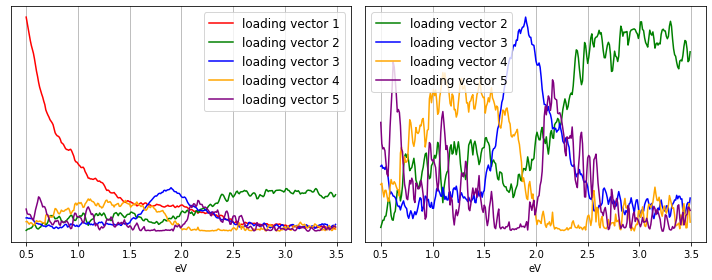

In [14]:
# visualize the loading vectors

fig, ax = plt.subplots(1, 2, figsize=(10, 4)) # all loading vectors
for i in range(nmf_num_comp):
    ax[0].plot(e_range, skl_comp_vectors[i], "-", c=color_rep[i+1], label="loading vector %d"%(i+1))
ax[0].grid()
ax[0].legend(fontsize="large")
ax[0].set_xlabel("eV", fontsize=10)
ax[0].tick_params(axis="x", labelsize=10)
ax[0].axes.get_yaxis().set_visible(False)

sel_nmf_comp = [2, 3, 4, 5] # part of those
for i in sel_nmf_comp:
    ax[1].plot(e_range, skl_comp_vectors[i-1], "-", c=color_rep[i], label="loading vector %d"%(i))
ax[1].grid()
ax[1].legend(fontsize="large")
ax[1].set_xlabel("eV", fontsize=10)
ax[1].tick_params(axis="x", labelsize=10)
ax[1].axes.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show()

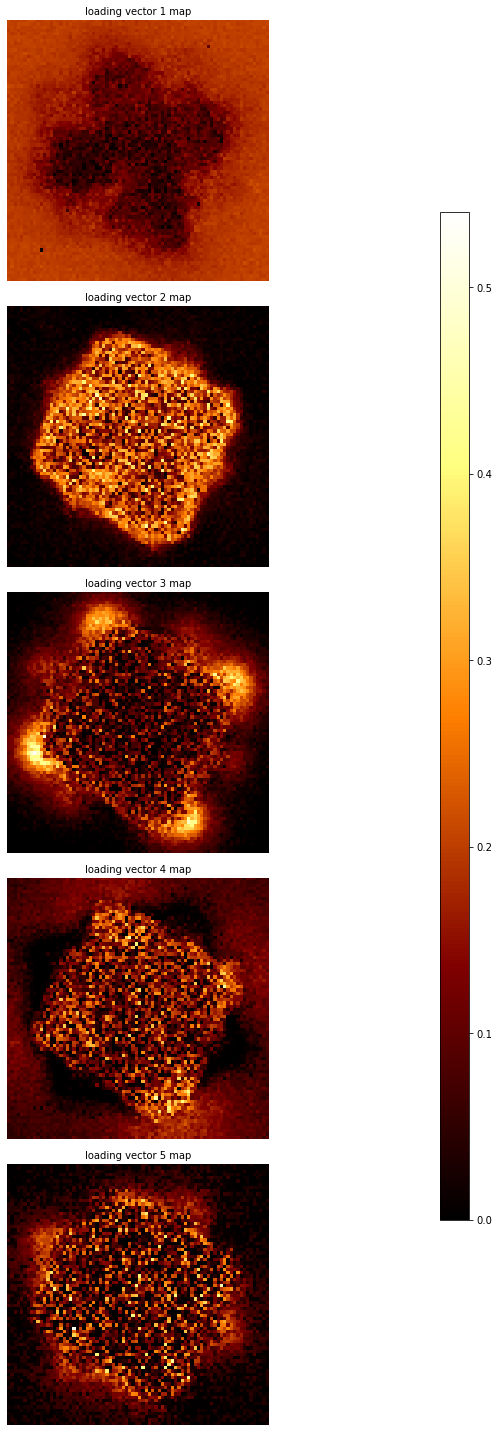

In [15]:
# visualize the coefficient maps

fig, ax = plt.subplots(num_comp, num_img, figsize=(10, 20))
min_val = np.min(coeffs)
max_val = np.max(coeffs)
if num_img != 1:
    for i in range(num_comp):
        for j in range(num_img):
            tmp = ax[i][j].imshow(coeffs_reshape[j][:, :, i], vmin=min_val, vmax=max_val, cmap="afmhot")
            ax[i][j].set_title("loading vector %d map"%(i+1), fontsize=10)
            ax[i][j].axis("off")
            
else:
    for i in range(num_comp):
        tmp = ax[i].imshow(coeffs_reshape[0][:, :, i], vmin=min_val, vmax=max_val, cmap="afmhot")
        ax[i].set_title("loading vector %d map"%(i+1), fontsize=10)
        ax[i].axis("off")

fig.tight_layout()
fig.colorbar(tmp, cax=fig.add_axes([0.92, 0.15, 0.04, 0.7]))
plt.show()

interactive(children=(IntText(value=1, description='1st loading vector', style=DescriptionStyle(description_wi…

C:\Users\RYUEMSL\AppData\Local\Temp/ipykernel_8352/1807570071.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


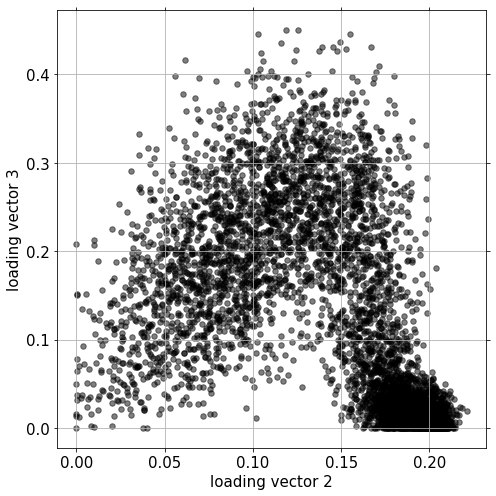

In [18]:
# visualize the dimensionality-reduced space (NMF)
# You can select two of loading vectors using the interative widgets
%matplotlib qt
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

def projection(c1, c2):
    ax.cla()
    ax.scatter(coeffs[:, c1-1], coeffs[:, c2-1], s=30, c="black", alpha=0.5)
    ax.grid()
    ax.set_xlabel("loading vector %d"%(c1+1), fontsize=15)
    ax.set_ylabel("loading vector %d"%(c2+1), fontsize=15)
    ax.tick_params(axis="both", labelsize=15)
    fig.canvas.draw()
    fig.tight_layout()

st = {"description_width": "initial"}
l1_widget = pyw.IntText(value=1, description="1st loading vector", style=st)
l2_widget = pyw.IntText(value=2, description="2nd loading vector", style=st)

pyw.interact(projection, c1=l1_widget, c2=l2_widget)
fig.show()

In [19]:
# non-linear dimensionality reduction (t-SNE)
# apply t-SNE to the coefficient matrix produced by NMF decomposition
# please visit the below link for the detailed information on t-SNE
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html?highlight=tsne#sklearn.manifold.TSNE
start = time.time()
#perplex = [30, 35, 40, 45, 50]
perplex = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50] # try several perplexities
embeddings = []
num_comp_vis = 2 # number of dimensions of final data before clustering
for order, p in enumerate(perplex):
    tmp_tsne = TSNE(n_components=num_comp_vis, perplexity=p, early_exaggeration=5.0, learning_rate=300.0, 
                init="random", n_iter=1000, verbose=0)
    tmp_tsne.fit_transform(coeffs)
    embeddings.append(tmp_tsne.embedding_)
    print("perplexity %.1f finished"%p)

perplexity 5.0 finished
perplexity 10.0 finished
perplexity 15.0 finished
perplexity 20.0 finished
perplexity 25.0 finished
perplexity 30.0 finished
perplexity 35.0 finished
perplexity 40.0 finished
perplexity 45.0 finished
perplexity 50.0 finished


In [ ]:
%matplotlib inline

In [ ]:
%matplotlib qt

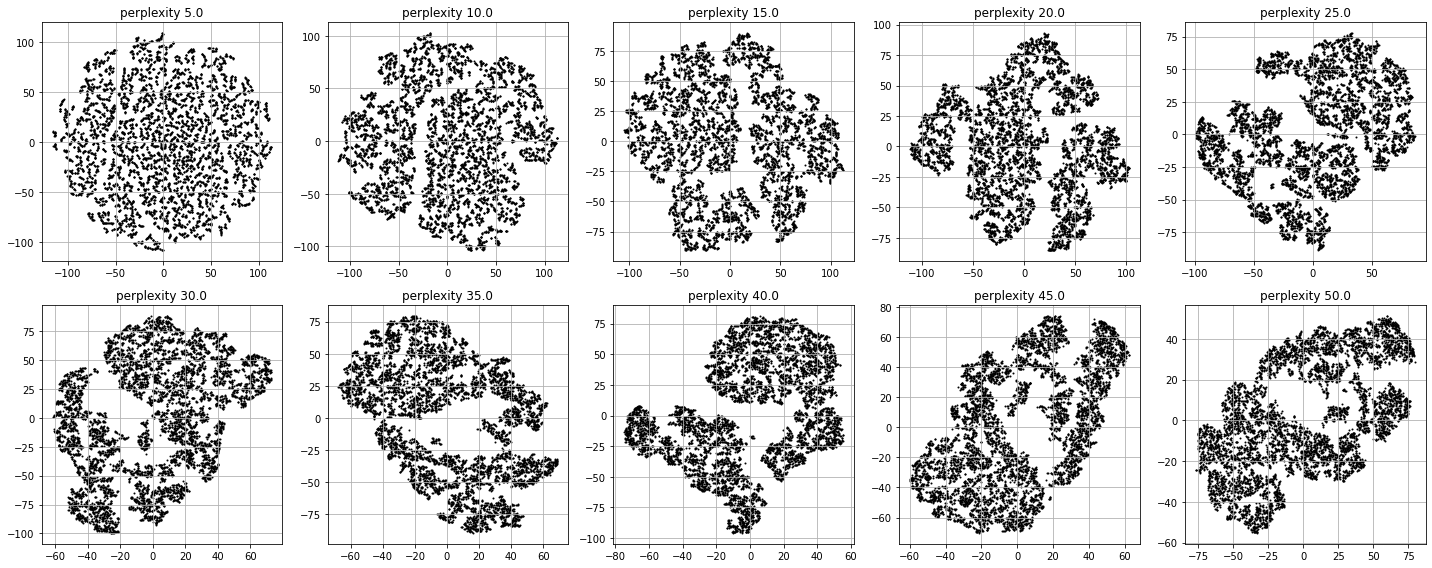

In [20]:
# visualize the dimensionality-reduced space (t-SNE) depending on the perplexity
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i, ai in enumerate(ax.flat):
    ai.scatter(embeddings[i][:, 0], embeddings[i][:, 1], s=1, c="black")
    ai.set_title("perplexity %.1f"%perplex[i])
    ai.grid()
fig.tight_layout()
plt.show()

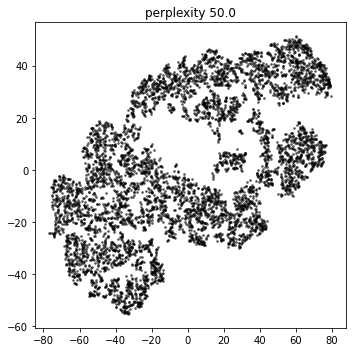

In [22]:
# select a proper dimensionality-reduced space for clustering
sel_ind = 9 # index of the list "perplex"
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(embeddings[sel_ind][:, 0], embeddings[sel_ind][:, 1], s=3, c="black", alpha=0.5)
ax.set_title("perplexity %.1f"%(perplex[sel_ind]))
fig.tight_layout()
plt.show()

In [23]:
# build a data matrix for clustering after performing t-SNE
num_comp = num_comp_vis
coeffs = embeddings[sel_ind].copy()

comp_axes = np.arange(num_comp)

if len(comp_axes) == 2:
    X = np.stack((coeffs[:, comp_axes[0]], coeffs[:, comp_axes[1]]), axis=1)
    print(X.shape)
    
elif len(comp_axes) == 3:
    X = np.stack((coeffs[:, comp_axes[0]], coeffs[:, comp_axes[1]], coeffs[:, comp_axes[2]]), axis=1)
    print(X.shape)

(6400, 2)


interactive(children=(FloatText(value=0.05, description='minimum # of samples in a neighborhood', style=Descri…

C:\Users\RYUEMSL\AppData\Local\Temp/ipykernel_8352/4217628288.py:101: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


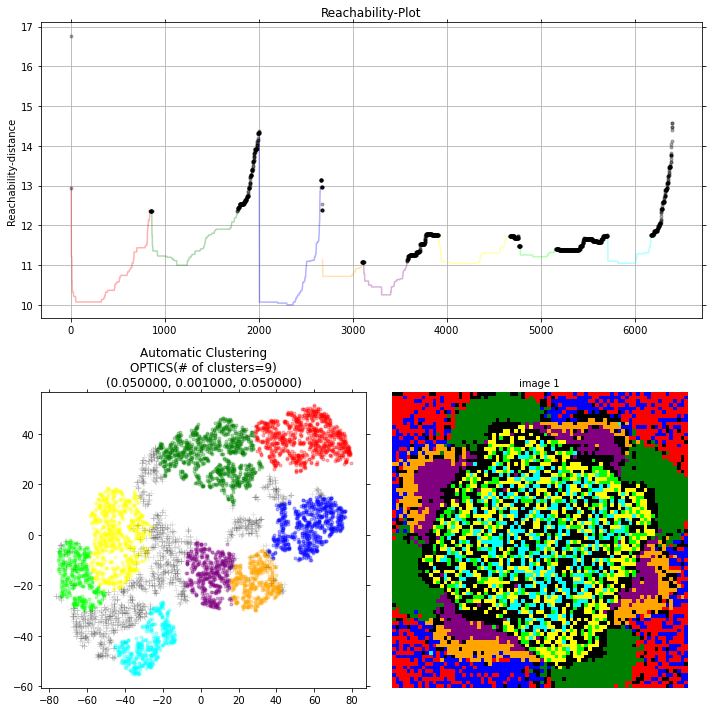

In [27]:
# unsupervised clustering (OPTICS)
# You can adjust the hyperparameters using the interative widgets
# please visit the below link for the detailed information on OPTICS
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html?highlight=optics#sklearn.cluster.OPTICS

#%matplotlib qt
fig = plt.figure(figsize=(10, 10))
G = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(G[0, :])

if X.shape[1] == 3:
    ax2 = plt.subplot(G[1, :2], projection="3d")
    
elif X.shape[1] == 2:
    ax2 = plt.subplot(G[1, :2])

ax3 = plt.subplot(G[1, 2:])

optics_before = [-1, -1, -1]
optics_object = []
label_result = {"label_0":[]}

def clustering(msample, steep, msize, img_sel):
    start = time.time()
    if msample <= 0:
        print("'min_sample' must be larger than 0")
        return
    
    if steep <= 0:
        print("'steepness' must be larger than 0")
        return
    
    if msize <= 0:
        print("'min_cluster_size' must be larger than 0")
        return
    
    optics_check = [msample, steep, msize]

    if optics_before != optics_check:
        ax1.cla()
        del label_result["label_0"]
        del optics_object[:]
        print("optics activated")
        clust = OPTICS(min_samples=msample, xi=steep, min_cluster_size=msize).fit(X)
        optics_object.append(clust)
        space = np.arange(len(X))
        reachability = clust.reachability_[clust.ordering_]
        labels = clust.labels_[clust.ordering_]
        labels_0 = clust.labels_
        label_result["label_0"] = labels_0

        for klass, color in zip(range(0, len(color_rep)), color_rep[1:]):
            Xk = space[labels == klass]
            Rk = reachability[labels == klass]
            ax1.plot(Xk, Rk, color, alpha=0.3)
        
        ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
        ax1.set_ylabel('Reachability-distance')
        ax1.set_title('Reachability-Plot')
        ax1.grid()
        
        ax2.cla()
        if X.shape[1] == 3:
            for klass, color in zip(range(0, len(color_rep)), color_rep[1:]):
                Xo = X[labels_0 == klass]
                ax2.scatter(Xo[:, 0], Xo[:, 1], Xo[:, 2], color=color, alpha=0.3, marker='.')
            ax2.plot(X[labels_0 == -1, 0], X[labels_0 == -1, 1], X[labels_0 == -1, 2], 'k+', alpha=0.1)
            ax2.set_title('Automatic Clustering\nOPTICS(# of clusters=%d)\n(%f, %f, %f)'%(len(np.unique(labels_0)), msample, steep, msize))

        elif X.shape[1] == 2:
            for klass, color in zip(range(0, len(color_rep)), color_rep[1:]):
                Xo = X[labels_0 == klass]
                ax2.scatter(Xo[:, 0], Xo[:, 1], color=color, alpha=0.3, marker='.')
            ax2.plot(X[labels_0 == -1, 0], X[labels_0 == -1, 1], 'k+', alpha=0.1)
            ax2.set_title('Automatic Clustering\nOPTICS(# of clusters=%d)\n(%f, %f, %f)'%(len(np.unique(labels_0)), msample, steep, msize))
        

    ax3.cla()
    
    label_reshape_0, _ = label_arrangement(label_result["label_0"], scan_shape)
    
    ax3.imshow(label_reshape_0[img_sel-1], cmap=custom_cmap, norm=norm)
    ax3.set_title("image %d"%(img_sel), fontsize=10)
    ax3.axis("off")

    fig.tight_layout()
    
    del optics_before[:]
    for i in range(len(optics_check)):
        optics_before.append(optics_check[i])
    print("%.2f min have passed"%((time.time()-start)/60))

    
st = {"description_width": "initial"}
msample_wg = pyw.FloatText(value=0.05, description="minimum # of samples in a neighborhood", style=st)
steep_wg = pyw.FloatText(value=0.001, description="minimum steepness", style=st)
msize_wg = pyw.FloatText(value=0.05, description="minimum # of samples in a cluster", style=st)
img_wg = pyw.Select(options=np.arange(num_img)+1, value=1, description="image selection", style=st)

pyw.interact(clustering, msample=msample_wg, steep=steep_wg, msize=msize_wg,  img_sel=img_wg)
fig.show()

In [28]:
# reshape the clustering result
label_selected = label_result["label_0"].copy()
label_sort = np.unique(label_selected)
label_reshape, hist = label_arrangement(label_selected, scan_shape)
num_label = len(label_sort)
print(label_sort) # label "-1" -> not a cluster
print(hist) # number of data points in each cluster

[-1  0  1  2  3  4  5  6  7]
[1509  843  912  653  419  461  760  380  463]


In [26]:
%matplotlib inline

In [ ]:
%matplotlib qt

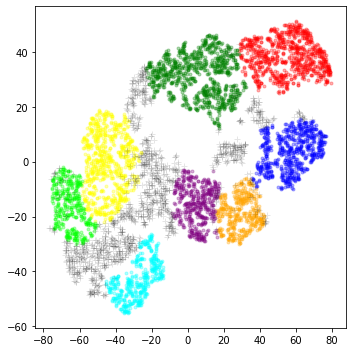

In [29]:
# clustering result - clusters in the final dimensionality-reduced space
# black points -> label "-1"
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for klass, color in zip(range(0, len(color_rep)), color_rep[1:]):
    Xo = X[label_selected == klass]
    ax.scatter(Xo[:, 0], Xo[:, 1], color=color, alpha=0.3, marker='.')
ax.plot(X[label_selected == -1, 0], X[label_selected == -1, 1], 'k+', alpha=0.1)
#ax.axis("off")
fig.tight_layout()
plt.show()

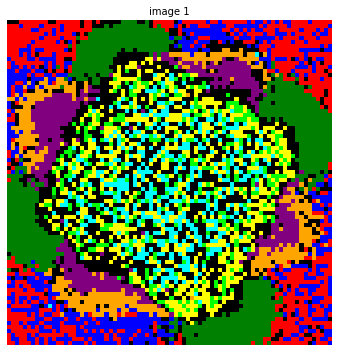

In [30]:
# clustering result - spatial distribution of each cluster
    
fig, ax = plt.subplots(1, num_img, figsize=(10, 5))
if num_img != 1:
    for i, axs in enumerate(ax.flat):
        axs.imshow(label_reshape[i], cmap=custom_cmap, norm=norm)
        axs.set_title("image %d"%(i+1), fontsize=10)
        axs.axis("off")

else:
    ax.imshow(label_reshape[0], cmap=custom_cmap, norm=norm)
    ax.set_title("image %d"%(1), fontsize=10)
    ax.axis("off")
#fig.colorbar(sm)
fig.tight_layout()

number of pixels in the label -1 cluster: 1509
number of pixels in the label 0 cluster: 843
number of pixels in the label 1 cluster: 912
number of pixels in the label 2 cluster: 653
number of pixels in the label 3 cluster: 419
number of pixels in the label 4 cluster: 461
number of pixels in the label 5 cluster: 760
number of pixels in the label 6 cluster: 380
number of pixels in the label 7 cluster: 463


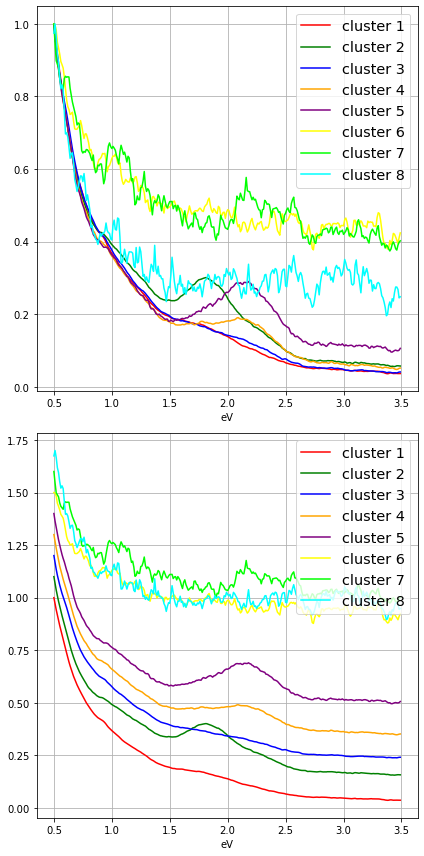

In [31]:
# clustering result - representative spectra
# average all of the spectra in each cluster
lines = np.zeros((num_label, n_channel))

for i in range(num_label):
    ind = np.where(label_selected == label_sort[i])
    print("number of pixels in the label %d cluster: %d"%(label_sort[i], hist[i]))
    lines[i] = np.mean(dataset_input[ind], axis=0)
    
fig, ax = plt.subplots(2, 1, figsize=(6, 12))

# normalize the representative spectra
lines = lines / np.max(lines, axis=1)[:, np.newaxis]

if -1 in label_sort: # to exclude the label -1 (unclassified data points)
    for i in range(1, num_label):
        ax[0].plot(e_range, (lines[i]), label="cluster %d"%(i), c=color_rep[i])
        ax[1].plot(e_range, (lines[i]+(i-1)*0.1), label="cluster %d"%(i), c=color_rep[i])
        
else:
    for i in range(0, num_label):
        ax[0].plot(e_range, (lines[i]), label="cluster %d"%(i+1), c=color_rep[i+1])
        ax[1].plot(e_range, (lines[i]+i*0.1), label="cluster %d"%(i+1), c=color_rep[i+1])

ax[0].grid()
ax[0].legend(fontsize="x-large")
ax[0].set_xlabel("eV")
ax[1].grid()
ax[1].legend(fontsize="x-large")
ax[1].set_xlabel("eV")
fig.tight_layout()
plt.show()